# Machine Learning

In [14]:
# Basics
import pandas as pd 
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler
)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import NearestNeighbors

# Imports for KNN and SVC/SVM models with GridSearchCV
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from sklearn import neighbors
from sklearn.pipeline import make_pipeline, Pipeline

# Metrics
from sklearn.metrics import (
    r2_score, accuracy_score, precision_score, recall_score, fbeta_score, f1_score
    )

# for SMOTE procedure
from imblearn.over_sampling import SMOTE 
from collections import Counter

## First models 

We are starting by testing multiple Machine Learning models on a cleaned simplified dataset.

Categorical => OneHotEncoder or one dimension with different values (1, 2, 3, 4, etc.)
- SEASON (4 classes)
- BASIN (7 classes)
- NATURE (6 classes)

Numeric => everything between 0 and 1
- LAT
- LON
- WIND 
- DIST2LAND
- STORM_SPEED
- STORM_DIR

### Choosing the pertient models

The different models can be found here :
https://scikit-learn.org/stable/machine_learning_map.html

| model | person | scores | encoding
| --- | --- | --- | --- | 
| Knn | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| Knn | -- | -- | -- | 
| SVM | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| SVM | -- | -- | -- | 
| Randomforest | Audrey | -- | OneHotEncoder/LabelBinarizer | 
| Randomforest | Audrey | -- | Categorical encoding | 
| LinearSVC | Arnaud | -- | OneHotEncoder/LabelBinarizer | 
| LinearSVC | Arnaud | -- | Categorical encoding | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 



The dataset can be imported with :

In [3]:
df = pd.read_parquet("data/base.parquet", engine="pyarrow")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45025 entries, 0 to 67409
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        45025 non-null  object 
 1   BASIN         45025 non-null  object 
 2   NATURE        45025 non-null  object 
 3   LAT           45025 non-null  float64
 4   LON           45025 non-null  float64
 5   WIND          45025 non-null  float64
 6   DIST2LAND     45025 non-null  int64  
 7   STORM_SPEED   45025 non-null  float64
 8   STORM_DIR     45025 non-null  float64
 9   TD9636_STAGE  45025 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


In [7]:
df.TD9636_STAGE.value_counts()

TD9636_STAGE
2.0    17079
1.0    15409
4.0    10590
0.0      853
3.0      742
5.0      225
6.0      127
Name: count, dtype: int64

<Axes: xlabel='STORM_DIR', ylabel='STORM_SPEED'>

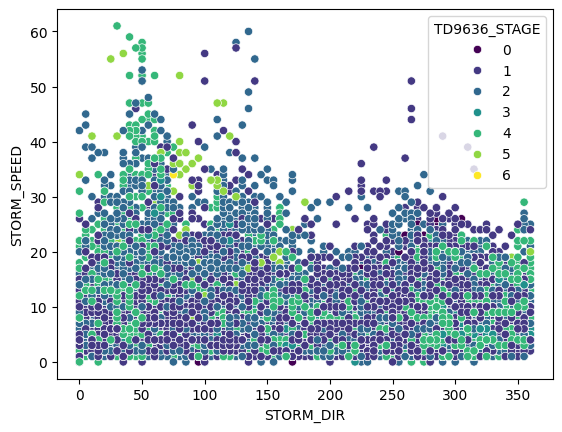

In [10]:
# plot
sns.scatterplot(
    x = 'STORM_DIR',
    y = 'STORM_SPEED',
    data = df,
    hue = 'TD9636_STAGE',
    palette = 'viridis',
)

# Encoding
NATURE AND BASIN columns encoded with the creation of new binary columns to avoid giving weight to certain values.

For the SEASON column, we used the OrdinalEncoder() method to give more weight to seasons with more frequent and stronger storms.


In [4]:
# Encoding the NATURE column
# create new binary columns for each NATURE category
DATA = pd.concat([df,
                 pd.get_dummies(df.NATURE)],axis=1).drop(columns='NATURE')
DATA = DATA.drop(columns='TS')
# We remove TS column (following K-1 rules)

# Same for BASIN
DATA = pd.concat([DATA,
                 pd.get_dummies(DATA.BASIN)],axis=1).drop(columns='BASIN')
DATA = DATA.drop(columns='WP')
# We remove WP column (following K-1 rules)

# Encoding the SEASON column
# Recode the season in integers. Give more importance to the seasons where the most storms occur
encoder = OrdinalEncoder(categories = [['Winter', 'Spring', 'Fall', 'Summer']]) 
DATA['SEASON'] = encoder.fit_transform(DATA[['SEASON']])


# Scaling the direction
STORM_DIR: as it is a direction it varies between 0° and 360° and 0° = 360°.
Thus it has to be handle in a specific way.

In [5]:
# scaling for direction: we need to extract the two components of the direction: 
DATA['STORM_DIR_X'] = np.cos(np.radians(DATA['STORM_DIR']))  # X component
DATA['STORM_DIR_Y'] = np.sin(np.radians(DATA['STORM_DIR']))  # Y component

# We can now drop the STORM_DIR column
DATA = DATA.drop(columns='STORM_DIR')

# Spliting the dataset into training and testing subset 
We used 80 % for training and 20 % for testing

In [6]:
# creation of the training and test datasets
DATA_train, DATA_test = train_test_split(DATA ,test_size = 0.2)

DATA_train.TD9636_STAGE.value_counts().sort_index()
DATA_test.TD9636_STAGE.value_counts().sort_index()

# get the values of the columns for the training data
X_train = DATA_train.drop(columns='TD9636_STAGE')
y_train = DATA_train['TD9636_STAGE']

# get the values of the columns for the test data
X_test = DATA_test.drop(columns='TD9636_STAGE')
y_test = DATA_test['TD9636_STAGE']

#### Scaling and Normalizing

We scale/normalize only numerical data : 
    - WIND, 
    - DIST2LAND, and 
    - STORM_SPEED

The data are scaled after spliting the data to avoid Data leakage.
StandardScaler() is the more appropriate method here (Gaussian data, not bounded data)

In [7]:
# Scaling 
col_to_scale = ['WIND', 'DIST2LAND', 'STORM_SPEED']

# Create the scaler
scaler = StandardScaler()

# Fit and transform the data:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[col_to_scale] = scaler.fit_transform(X_train_scaled[col_to_scale])
X_test_scaled[col_to_scale] = scaler.transform(X_test_scaled[col_to_scale])


## SMOTE procedure to balance the sampling between stages
We used smote procedure only on training data.
Test data need to stay nice and clean as it is better to test our model with empirical data rather than simulated. 

We apply SMOTE after splitting but before scaling.

In [8]:
# SMOTE procedure

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample training data
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

In [9]:
coutner_y_train = Counter(y_train)
counter_y_SMOTE = Counter(y_SMOTE)
print(coutner_y_train, 
      counter_y_SMOTE)

Counter({2.0: 13703, 1.0: 12347, 4.0: 8420, 0.0: 658, 3.0: 600, 5.0: 187, 6.0: 105}) Counter({1.0: 13703, 2.0: 13703, 4.0: 13703, 3.0: 13703, 0.0: 13703, 5.0: 13703, 6.0: 13703})


# Scaling of the smote training dataset

In [10]:
# Scaling 
col_to_scale = ['WIND', 'DIST2LAND', 'STORM_SPEED']

# Create the scaler
scaler = StandardScaler()

# Fit and transform the data:
X_SMOTE_scaled = X_SMOTE.copy()
X_SMOTE_scaled[col_to_scale] = scaler.fit_transform(X_SMOTE_scaled[col_to_scale])


#### KNN with GridSearchCV 
Using SMOTE data

In [21]:
def big_fit(X_train, y_train, X_test, y_test):

    # storing the list of estimators we want to train
    estimators = [
        # ("rfr", RandomForestClassifier(random_state=42)),
        # ("hgb", HistGradientBoostingClassifier(random_state=42)),
        # ("svc", SVC()),
        # ("knn", NearestNeighbors())
        ("knn", KNeighborsClassifier())
    ]
    
    # initializing dict for the models' scores
    default_scores = dict()

    # we need to loop to store the scores for each model 
    # key = model name, value = score
    for estimator in estimators:
        pipe = Pipeline(steps=[estimator])
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        score = r2_score(y_test, y_pred) * 100
        name = estimator[0]
        default_scores[name] = round(score, 2)

    param_grids = [
        # {
        #    "rfr__n_estimators": [1,10,50,100,150,200],
        #    "rfr__min_samples_leaf": [1, 2, 4],
        #    "rfr__max_depth": [5, 10, 20, 50],
        #    "rfr__max_features": ["sqrt", "log2", None],
        #},
        # {
        #     "hgb_learning_rate": [1.01, 0.1, 0.2, 0.5],
        #     "hgb_max_iter": [50, 100, 200, 500],
        #     "hgb_max_bins": [64, 128, 256],
        #     "hgb_l2_regularization": [0, 0.01, 0.1, 1]
        # },
        # {
        #     "svc_C": [0.01, 0.1, 1, 10, 100],
        #     "svc_kernel": ["linear", "poly", "rbf", "sigmoid"],
        #     "svc_gamma": ["scale", "auto"],
        #     "svc_degree": [2, 3, 4, 5]
        # },
         {
             "knn__n_neighbors": [2, 3, 4, 5, 10, 20],
             "knn__weights": ["uniform", "distance"],
             "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
             "knn__p": [1, 2]
         },
       ]

    # dictionaries to store the different datas
    best_estimators = dict()
    best_params = dict()
    best_scores = dict()
    predict_scores = dict()

    # error rates
    accuracy_err = dict()
    precision_err = dict()
    recall_err = dict()
    fbeta_err = dict()
    f1_err = dict()
    
    # dictionary representing the distribution of errors
    err = dict()

    # scores
    feature_names = dict()
    feature_scores = dict()

    # loop to run the gridSearch for each model of our list
    for estimator, param_grid in zip(estimators, param_grids):
        print(f"estimator: {estimator}, params: {param_grid}")
        pipe_line = Pipeline(steps=[estimator])
        grid = GridSearchCV(
            pipe_line,
            param_grid,
            cv=5, 
            return_train_score=True,
            verbose=1,
        )

        name = estimator[0]
        print(f"Algo : {name}")

        # training phase with the features and target of the "train" set
        grid.fit(X_train, y_train)

        # storing best_estimator, best_params et best_scores in the corresponding dictionaries
        best_estimators[name] = grid.best_estimator_
        best_params[name] = grid.best_params_
        best_scores[name] = round(grid.best_score_ * 100, 2)
        
        # classification (prediction) test with the features and target of the "test" set
        y_pred = grid.predict(X_test)
        score = r2_score(y_test, y_pred) * 100
        predict_scores[name] = round(score, 2)


        # storing mean, median and absolute errors in the corresponding dictionaries
        # by default average is set to binary but in our case we are multi class
        # chose average = "weighted" so that it calculates the metric for each class separately, 
        # then averages them based on class frequency but we might try "micro" or "macro" instead
        accuracy_err[name] = accuracy_score(y_test, y_pred)
        precision_err[name] = precision_score(y_test, y_pred, average="weighted")
        recall_err[name] = recall_score(y_test, y_pred, average="weighted")
        fbeta_err[name] = fbeta_score(y_test, y_pred, beta=1, average="weighted")  # need to specify beta=1
        f1_err[name] = f1_score(y_test, y_pred, average="weighted")
        
        # Store classification errors (misclassified instances)
        err[name] = (y_test != y_pred).astype(int)  # 1 for misclassified, 0 for correct

        feature_names[name] = pipe_line[:-1].get_feature_names_out()

        try:
            print("coef_.flatten")
            feature_scores[name] = pipe_line.named_steps[name].coef_.flatten()
        
        except:
            print("feature_importances_.flatten")
            feature_scores[name] = pipe_line.named_steps[name].feature_importances_.flatten()
    
    return default_scores, best_scores, predict_scores, best_params, best_estimators, accuracy_err, precision_err, recall_err, fbeta_err, f1_err, err, feature_names, feature_scores

In [22]:
default_scores, best_scores, predict_scores, best_params, best_estimators, accuracy_err, precision_err, recall_err, fbeta_err, f1_err, err, feature_scores, feature_names = big_fit(X_SMOTE_scaled, y_SMOTE, X_test_scaled, y_test)  

estimator: ('knn', KNeighborsClassifier()), params: {'knn__n_neighbors': [2, 3, 4, 5, 10, 20], 'knn__weights': ['uniform', 'distance'], 'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'knn__p': [1, 2]}
Algo : knn
Fitting 5 folds for each of 96 candidates, totalling 480 fits
coef_.flatten
feature_importances_.flatten


AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [23]:
results = pd.DataFrame({
    "Name": [b for b in best_estimators.keys()],
    "Default score": list(default_scores.values()),
    "Grid Cross-val score": list(best_scores.values()),
    "Grid Test score": list(predict_scores.values()),
    "Accuracy": list(accuracy_err.values()),
    "Precision": list(precision_err.values()),
    "Recall": list(recall_err.values()),
    "FBeta": list(fbeta_err.values()),
    "F1": list(f1_err.values()),
})
results.sort_values(by="Grid Test score", ascending=False) 

NameError: name 'best_estimators' is not defined

In [ ]:
best_estimator = max(predict_scores, key=predict_scores.get)
best_estimator

In [ ]:
# getting the best model's hyperparameters
best_model = best_estimators["rfr"]  
print(best_model.get_params())

In [ ]:
best_estimators[best_estimator] 